### **Import**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import copy
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
TrainBBC_df=pd.read_csv('/content/drive/My Drive/ML/BBC News Train.csv') #### used
TestBBC_df=pd.read_csv('/content/drive/My Drive/ML/BBC News Test.csv') #### used
dataset1_df=pd.read_json('/content/drive/My Drive/ML/News_Category_Dataset_v2.json', lines=True)

print(TrainBBC_df.shape)
print(TestBBC_df.shape)
print(dataset1_df.shape)


(1490, 3)
(735, 2)
(200853, 6)


In [ ]:
TrainBBC_df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [ ]:
dataset1_df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


### **Pre-Processing**

##### Train_BBC Dataset Clean

In [ ]:
TrainBBC_df=TrainBBC_df.sort_values('ArticleId')
TrainBBC_df.reset_index(inplace=True)
TrainBBC_df.drop(columns=['index','ArticleId'],inplace=True)
temp=TrainBBC_df.copy()
for i in range(TrainBBC_df.shape[0] ):
  if  temp.iloc[i,temp.columns.get_loc('Category')]=="sport":
    temp.iloc[i,temp.columns.get_loc('Category')]="sports"
  
TrainBBC_df=temp
TrainBBC_df.head()


,Text,Category
0,worldcom boss left books alone former worldc...,business
1,yeading face newcastle in fa cup premiership s...,sports
2,blair prepares to name poll date tony blair is...,politics
3,last star wars not for children the sixth an...,entertainment
4,berlin cheers for anti-nazi film a german movi...,entertainment


In [ ]:
print(TrainBBC_df['Category'].value_counts())

sports           346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64


In [ ]:
TrainBBC_df.isna().sum().sum()

0

In [ ]:
TrainBBC_df['Category'].value_counts()

sports           346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

##### dataset1_df clean up

In [ ]:
dataset1_df.drop(columns=[ 'authors', 'link','date'],inplace=True)
dataset1_df.rename(
    columns={
        'category':'Category',
        'headline': 'Text'
    }, inplace=True
)
dataset1_df.columns

Index(['Category', 'Text', 'short_description'], dtype='object')

In [ ]:
temp=dataset1_df.copy()
for i in range(temp.shape[0]):
  temp.iloc[i,temp.columns.get_loc('Category')] =  temp.iloc[i,temp.columns.get_loc('Category')].lower()
  temp.iloc[i,temp.columns.get_loc('Text')]=temp.iloc[i,temp.columns.get_loc('Text')]+" "+temp.iloc[i,temp.columns.get_loc('short_description')]

dataset1_df=temp


In [ ]:
dataset1_df.drop(columns=['short_description'],inplace=True)
dataset1_df.head()
print(dataset1_df.shape)

(200853, 2)


##### Appending 2 DataFrames 

In [ ]:
dataset_df=dataset1_df.append(TrainBBC_df)
dataset_df.reset_index(inplace=True)

##### Dropping rows whose Text's word count is very less.

In [ ]:
veryless=15
cpy=dataset_df.copy()
count=0
word_count=[]
for i in range(len(cpy)):
  wc=len(cpy.iloc[i,cpy.columns.get_loc('Text')].split())
  if wc<veryless:
    count=count+1
  word_count.append(wc)
print(count," rows dropped")
cpy['word_count']=word_count

cpy= cpy[cpy['word_count'] >= veryless]
cpy.drop(columns=['word_count'],inplace=True)
dataset_df=cpy



26878  rows dropped


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
dataset_df["Category"].replace("arts", "arts & culture")

0                 crime
1         entertainment
2         entertainment
3         entertainment
4         entertainment
              ...      
202338           sports
202339         business
202340         business
202341    entertainment
202342         politics
Name: Category, Length: 175465, dtype: object

In [ ]:
dataset_df['Category'].value_counts()

politics          28673
wellness          17815
entertainment     12522
style & beauty     9491
travel             9286
parenting          8653
food & drink       5472
queer voices       5461
business           5339
healthy living     4979
sports             4195
home & living      4019
black voices       4005
comedy             3938
weddings           3638
the worldpost      3567
divorce            3412
parents            3275
impact             3071
women              2950
crime              2627
media              2211
tech               2169
world news         2128
green              2024
weird news         1831
religion           1827
science            1714
money              1704
taste              1646
environment        1320
worldpost          1266
arts & culture     1260
style              1242
fifty              1046
good news           999
culture & arts      996
latino voices       989
college             906
education           901
arts                898
Name: Category, 

In [ ]:
dataset_df.Category=dataset_df.Category.replace({"arts": "arts & culture",
                                                  "culture & arts":"arts & culture",
                                                 "the worldpost" :"world news",
                                                 "worldpost":"world news",
                                                 "parenting":"parents",
                                                 "style":"style & beauty",
                                                 "marriage":"marriage life",
                                                 "divorce":"marriage life",
                                                 "weddings":"marriage life",
                                                 "green":"environment",
                                                 "college":"education",
                                                 "taste":"food & drink",
                                                 "wellness":"healthy living",
                                                "black voices":"minority voices",
                                                 "queer voices":"minority voices",
                                                 "latino voices":"minority voices"
                                                 })

In [ ]:
indexname=dataset_df[dataset_df['Category']=='good news'].index
dataset_df.drop(indexname, inplace=True)
indexname=dataset_df[dataset_df['Category']=='impact'].index
dataset_df.drop(indexname, inplace=True)
indexname=dataset_df[dataset_df['Category']=='fifty'].index
dataset_df.drop(indexname, inplace=True)

In [ ]:
dataset_df['Category'].value_counts()

politics           28673
healthy living     22794
entertainment      12522
parents            11928
style & beauty     10733
minority voices    10455
travel              9286
food & drink        7118
marriage life       7050
world news          6961
business            5339
sports              4195
home & living       4019
comedy              3938
environment         3344
arts & culture      3154
women               2950
crime               2627
media               2211
tech                2169
weird news          1831
religion            1827
education           1807
science             1714
money               1704
Name: Category, dtype: int64

In [ ]:
training_data=dataset_df.sample(frac=0.8,random_state=69)
testing_data=dataset_df.drop(training_data.index)
training_data.reset_index(inplace=True)
testing_data.reset_index(inplace=True)
print(training_data.shape)
print(testing_data.shape)
training_data.drop(columns=['level_0','index'],inplace=True)
testing_data.drop(columns=['level_0','index'],inplace=True)

(136279, 4)
(34070, 4)


### **Pre-Processing Synopsis**


testing_data : Contains 20% of around 20,000 news articles to Test the model



*   training_data : Contains 80% of around 20,000 news articles to train the model
*   testing_data : Contains 20% of around 20,000 news articles to Test the model





In [ ]:
display(training_data.head())
print(training_data.shape)
display(testing_data.head())
print(testing_data.shape)

,Category,Text
0,world news,Israel's Bedouin Schools Thrive in Negev Deser...
1,politics,HUFFPOLLSTER: What You Need To Know About Brex...
2,world news,Italy Earthquake Death Toll Climbs To Nearly 2...
3,media,Nate Silver Slams Vox For Aggregating Bill Cos...
4,healthy living,Should You Check Your E-Mail? Let This Chart D...


(136279, 2)


,Category,Text
0,crime,There Were 2 Mass Shootings In Texas Last Week...
1,entertainment,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
2,entertainment,Julianna Margulies Uses Donald Trump Poop Bags...
3,entertainment,Justin Timberlake Visits Texas School Shooting...
4,world news,South Korean President Meets North Korea's Kim...


(34070, 2)


### **Exploratory Data Analysis**

##### Total no of Categories

In [ ]:
print("All Categories We have now :")
print(dataset_df['Category'].value_counts())
print()
print("Number of Categories We have Now is : ")
print(len(dataset_df['Category'].value_counts()))


All Categories We have now :
politics           28673
healthy living     22794
entertainment      12522
parents            11928
style & beauty     10733
minority voices    10455
travel              9286
food & drink        7118
marriage life       7050
world news          6961
business            5339
sports              4195
home & living       4019
comedy              3938
environment         3344
arts & culture      3154
women               2950
crime               2627
media               2211
tech                2169
weird news          1831
religion            1827
education           1807
science             1714
money               1704
Name: Category, dtype: int64

Number of Categories We have Now is : 
25


##### Mean,std, Min , Max

In [ ]:
temp=training_data['Category'].value_counts().to_frame().reset_index()
print("Mean articles per category : ", temp['Category'].mean())
print("Standard Deviation : ",temp['Category'].std())
print("____________________________________________________")
print("Category with Least Number of Articles : ")
print("Category : "+ temp.iloc[temp['Category'].idxmin()]['index'])
print("Count : ", temp.iloc[temp['Category'].idxmin()]['Category'])
print("____________________________________________________")
print("Category with Most Number of Articles : ")
print("Category : "+ temp.iloc[temp['Category'].idxmax()]['index'])
print("Count : ", temp.iloc[temp['Category'].idxmax()]['Category'])


Mean articles per category :  5451.16
Standard Deviation :  5377.20331337149
____________________________________________________
Category with Least Number of Articles : 
Category : money
Count :  1360
____________________________________________________
Category with Most Number of Articles : 
Category : politics
Count :  22998


##### Barplot - Number of articles in each category

Text(0, 0.5, 'Categories')

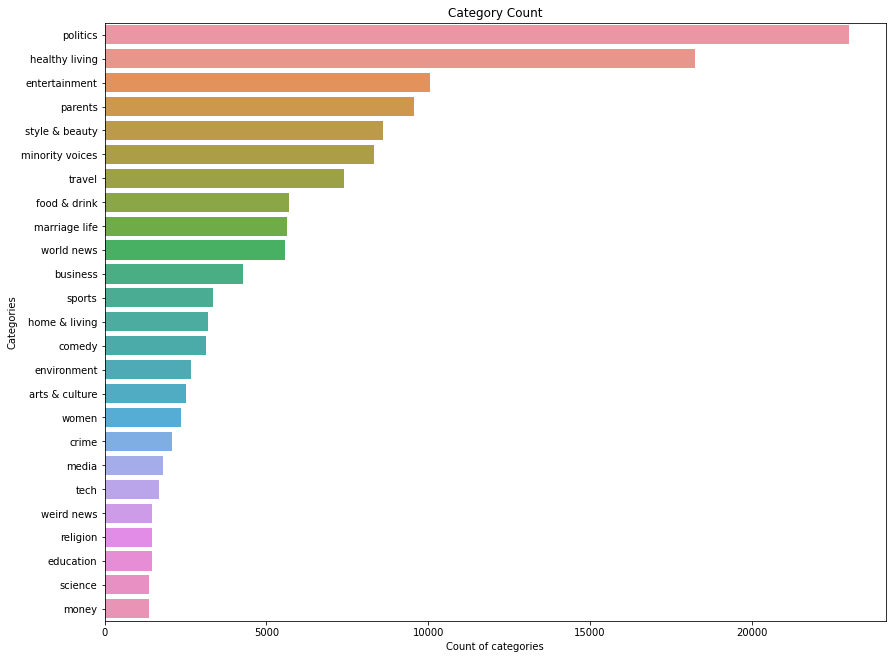

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 11)
ax=sns.barplot(data=temp,y='index',x='Category',ax=ax)
ax.set_title('Category Count')
ax.set_xlabel('Count of categories')
ax.set_ylabel('Categories')

##### Mean, Std, Min, Max - Word count per Article

In [ ]:
train_copy=training_data.copy()
count=0
word_count=[]
for i in range(len(train_copy)):
  wc=len(train_copy.iloc[i,train_copy.columns.get_loc('Text')].split())
  if wc<5:
    count=count+1
  word_count.append(wc)
train_copy['word_count']=word_count
print("Average Words per article : ", train_copy['word_count'].mean())
print("Std of Words per article : ", train_copy['word_count'].std())
print("Articles that have Maximum words : ", train_copy['word_count'].max())
print("Articles that have Minimum words : ", train_copy['word_count'].min())

Average Words per article :  35.12693078170518
Std of Words per article :  40.314056473899264
Articles that have Maximum words :  3345
Articles that have Minimum words :  15


##### Striplot,Barplot- Mean word count for each Category

Text(0.5, 1.0, 'Mean Word count for Each Category ')

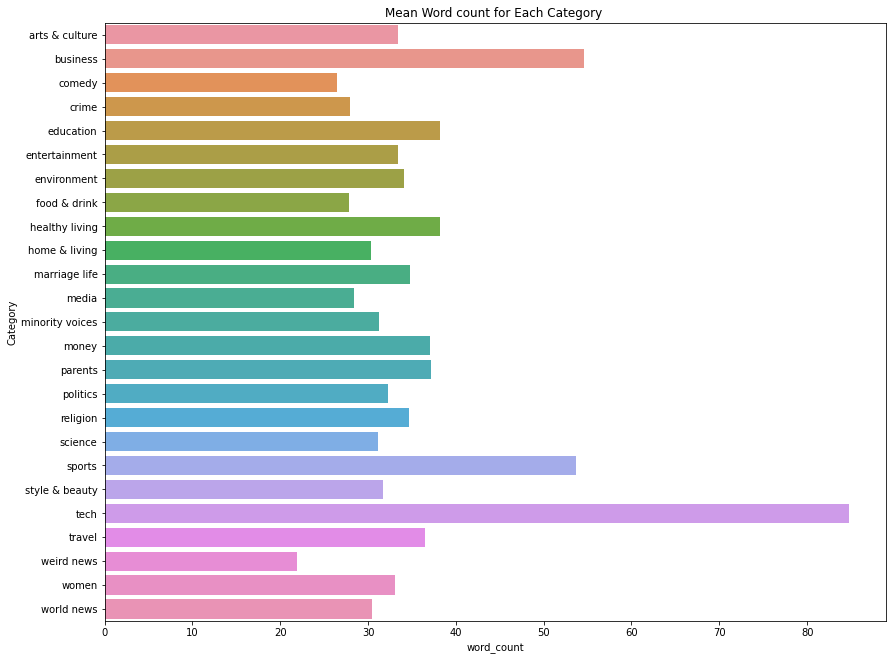

In [ ]:
mean_cat=train_copy.groupby('Category').mean().reset_index()
fig, ax = plt.subplots()
fig.set_size_inches(14, 11)
ax=sns.barplot(data=mean_cat,x='word_count',y='Category')
ax.set_title('Mean Word count for Each Category ')

Text(0.5, 1.0, 'Mean Word count for Each Category ')

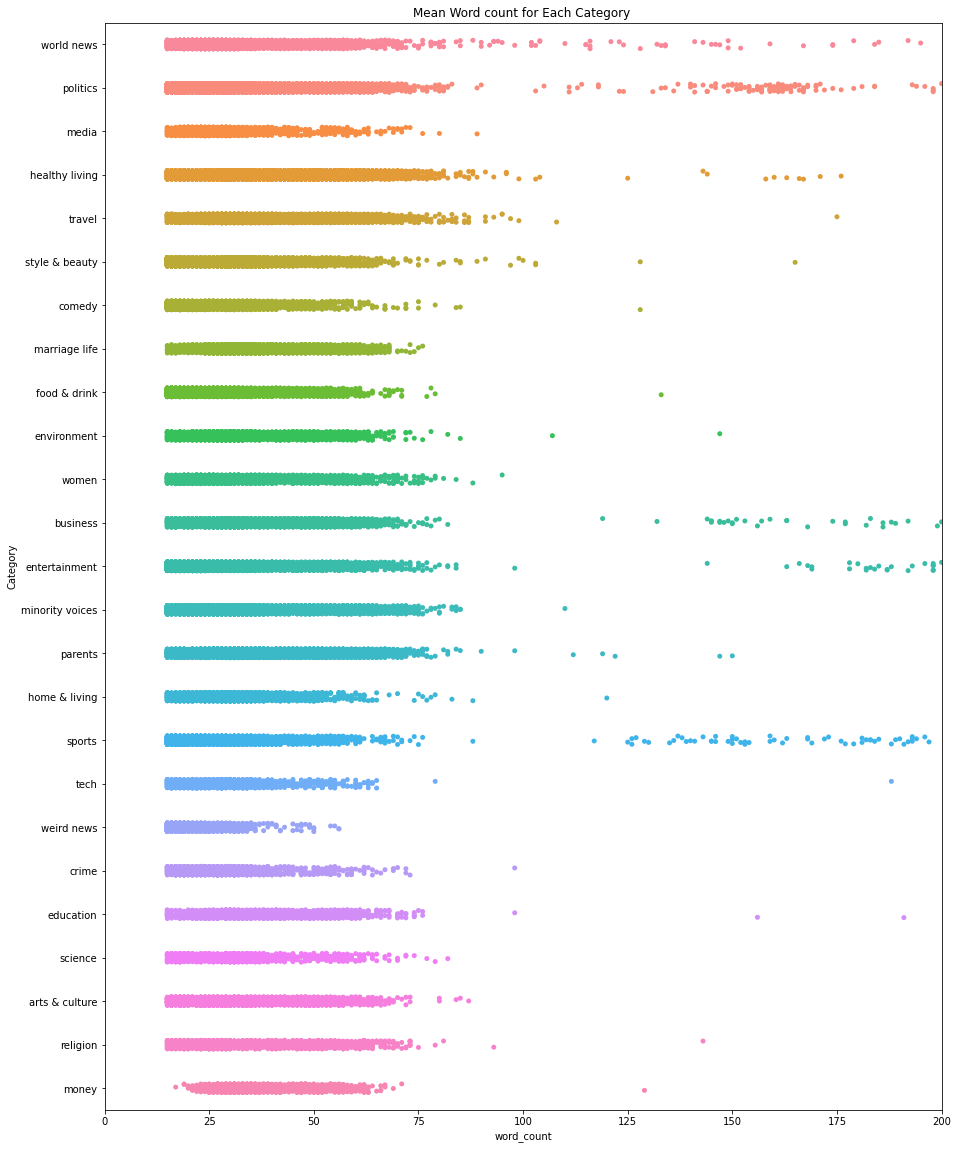

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15,20)
plt.xlim((0,200))
ax=sns.stripplot(data=train_copy,x='word_count',y='Category')
ax.set_title('Mean Word count for Each Category ')

##### Stripplot, Boxplot, Violinplot - how is number of articles on a category distributed

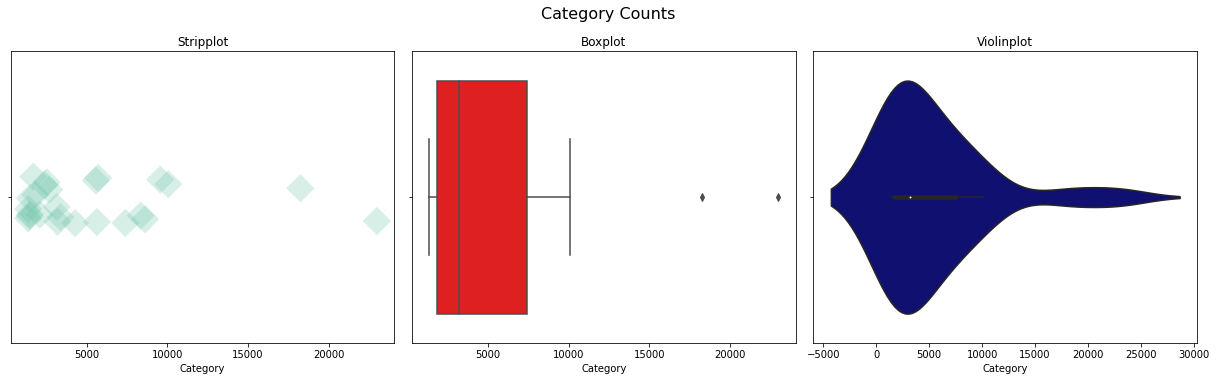

In [ ]:
plt.rcParams["figure.figsize"] = [17, 5]
plt.rcParams["figure.autolayout"] = True
fig, axes = plt.subplots(1, 3)
fig.suptitle("Category Counts", fontsize=16,y=1.05)
axes[0].set_title("Stripplot")
axes[1].set_title("Boxplot")
axes[2].set_title("Violinplot")

sns.stripplot(x=temp['Category'], palette="Set2", size=20, marker="D",edgecolor="gray", alpha=.25,ax=axes[0])
sns.boxplot(x=temp['Category'],ax=axes[1],color='red')
sns.violinplot(x=temp['Category'],ax=axes[2],color='navy')

## **Vectorization**

In [ ]:
category_train=training_data['Category'].tolist()
category_test=testing_data['Category'].tolist()
title_train=training_data['Text'].tolist()
title_test=testing_data['Text'].tolist()
print(len(category_train))
print(len(category_test))

136279
34070


In [ ]:
type(title_train[0])

str

In [ ]:
tokenizer = nltk.tokenize.RegexpTokenizer(r"\w+")
stop_words = nltk.corpus.stopwords.words("english")
vectorizer = CountVectorizer(tokenizer=tokenizer.tokenize, stop_words=stop_words)

vectorizer.fit(iter(title_train))
Xtr = vectorizer.transform(iter(title_train))
Xte = vectorizer.transform(iter(title_test))

encoder = LabelEncoder()
encoder.fit(category_train)
Ytr = encoder.transform(category_train)
Yte = encoder.transform(category_test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


##**Feature Reduction**

In [ ]:
print("Number of features before reduction : ", Xtr.shape[1])
selection = VarianceThreshold(threshold=0.00005)
Xtr_whole = copy.deepcopy(Xtr)
Ytr_whole = copy.deepcopy(Ytr)
selection.fit(Xtr)
XtrTemp = selection.transform(Xtr)
XteTemp = selection.transform(Xte)
print("Number of features after reduction : ", XtrTemp.shape[1])

Number of features before reduction :  80828
Number of features after reduction :  27823


### Vectorizer for Feature Reduced Data

In [ ]:
dummy=copy.deepcopy(Xtr)
aa=vectorizer.inverse_transform(dummy)

In [ ]:
listpass=[]
for i  in range(len(aa)):
  pass1=str(' '.join(aa[i]))
  listpass.append(pass1)
print(type(listpass[0]))

<class 'str'>


In [ ]:
vectorizer1 = CountVectorizer(tokenizer=tokenizer.tokenize, stop_words=stop_words)
vectorizer1.fit(iter(listpass))
bb = vectorizer1.transform(iter(listpass))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


In [ ]:
bb.shape

(136279, 27823)

##**Algorithms Before Sampling**

###Logistic Regression

In [ ]:
ll = LogisticRegression(random_state=69)
ll.fit(Xtr, Ytr)
pred = ll.predict(Xte)
print(classification_report(Yte, pred, target_names=encoder.classes_))

                 precision    recall  f1-score   support

 arts & culture       0.57      0.44      0.49       643
       business       0.52      0.47      0.49      1071
         comedy       0.54      0.44      0.49       810
          crime       0.57      0.48      0.52       537
      education       0.50      0.36      0.42       356
  entertainment       0.63      0.70      0.66      2473
    environment       0.56      0.47      0.51       669
   food & drink       0.74      0.76      0.75      1419
 healthy living       0.70      0.79      0.74      4543
  home & living       0.78      0.74      0.76       831
  marriage life       0.83      0.79      0.81      1423
          media       0.50      0.39      0.44       406
minority voices       0.61      0.57      0.59      2117
          money       0.52      0.39      0.45       344
        parents       0.67      0.70      0.69      2376
       politics       0.72      0.80      0.76      5675
       religion       0.59    

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


### Decision Tree

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(Xtr, Ytr)
pred = dt.predict(Xte)
print(classification_report(Yte, pred, target_names=encoder.classes_))

                 precision    recall  f1-score   support

 arts & culture       0.35      0.29      0.31       643
       business       0.31      0.29      0.30      1071
         comedy       0.40      0.32      0.35       810
          crime       0.35      0.29      0.32       537
      education       0.31      0.27      0.29       356
  entertainment       0.42      0.49      0.45      2473
    environment       0.34      0.27      0.30       669
   food & drink       0.56      0.57      0.56      1419
 healthy living       0.53      0.63      0.58      4543
  home & living       0.56      0.51      0.53       831
  marriage life       0.74      0.69      0.71      1423
          media       0.25      0.21      0.23       406
minority voices       0.49      0.42      0.45      2117
          money       0.27      0.18      0.22       344
        parents       0.54      0.60      0.57      2376
       politics       0.65      0.69      0.67      5675
       religion       0.28    

### Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=40)
rf.fit(Xtr, Ytr)
pred = rf.predict(Xte)
print(classification_report(Yte, pred, target_names=encoder.classes_))

                 precision    recall  f1-score   support

 arts & culture       0.60      0.28      0.38       643
       business       0.50      0.30      0.38      1071
         comedy       0.68      0.32      0.44       810
          crime       0.55      0.34      0.42       537
      education       0.46      0.26      0.33       356
  entertainment       0.52      0.65      0.58      2473
    environment       0.56      0.23      0.33       669
   food & drink       0.61      0.71      0.66      1419
 healthy living       0.55      0.82      0.66      4543
  home & living       0.73      0.58      0.64       831
  marriage life       0.81      0.76      0.78      1423
          media       0.55      0.16      0.25       406
minority voices       0.70      0.43      0.53      2117
          money       0.57      0.12      0.19       344
        parents       0.61      0.73      0.67      2376
       politics       0.63      0.86      0.73      5675
       religion       0.63    

### Multinomial NB

In [ ]:
nb = MultinomialNB()
nb.fit(Xtr, Ytr)
pred = nb.predict(Xte)
print(classification_report(Yte, pred, target_names=encoder.classes_))

                 precision    recall  f1-score   support

 arts & culture       0.84      0.19      0.31       643
       business       0.51      0.46      0.49      1071
         comedy       0.73      0.22      0.34       810
          crime       0.62      0.41      0.49       537
      education       0.69      0.08      0.14       356
  entertainment       0.57      0.76      0.65      2473
    environment       0.66      0.32      0.43       669
   food & drink       0.78      0.73      0.75      1419
 healthy living       0.61      0.87      0.72      4543
  home & living       0.90      0.54      0.68       831
  marriage life       0.83      0.69      0.76      1423
          media       0.69      0.09      0.16       406
minority voices       0.59      0.49      0.54      2117
          money       0.70      0.06      0.11       344
        parents       0.58      0.73      0.64      2376
       politics       0.65      0.88      0.75      5675
       religion       0.85    

### KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=121)
knn.fit(Xtr, Ytr)
pred = knn.predict(Xte)
print(classification_report(Yte, pred, target_names=encoder.classes_))

                 precision    recall  f1-score   support

 arts & culture       0.33      0.06      0.10       643
       business       0.49      0.08      0.14      1071
         comedy       0.07      0.31      0.12       810
          crime       0.50      0.07      0.12       537
      education       0.51      0.06      0.11       356
  entertainment       0.25      0.51      0.34      2473
    environment       0.71      0.08      0.15       669
   food & drink       0.13      0.77      0.23      1419
 healthy living       0.43      0.36      0.39      4543
  home & living       0.69      0.27      0.39       831
  marriage life       0.90      0.26      0.40      1423
          media       0.58      0.07      0.13       406
minority voices       0.37      0.20      0.26      2117
          money       0.50      0.02      0.03       344
        parents       0.57      0.24      0.34      2376
       politics       0.60      0.62      0.61      5675
       religion       0.59    

## **Algorithms After Sampling**

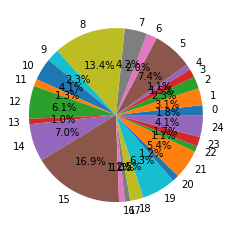

In [ ]:
labels = list(set(Ytr))
counts = []
for label in labels:
    counts.append(np.count_nonzero(Ytr == label))
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.show()


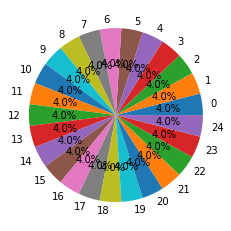

In [ ]:
sm = SMOTE(random_state=42)
XtrS, YtrS = sm.fit_resample(Xtr, Ytr)
labels = list(set(YtrS))
counts = []
for label in labels:
    counts.append(np.count_nonzero(YtrS == label))
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.show()

###Logistic Regression

In [ ]:
ll2 = LogisticRegression(random_state=69)
ll2.fit(XtrS, YtrS)
pred = ll2.predict(Xte)
print(classification_report(Yte, pred, target_names=encoder.classes_))

                 precision    recall  f1-score   support

 arts & culture       0.48      0.46      0.47       643
       business       0.45      0.49      0.47      1071
         comedy       0.47      0.45      0.46       810
          crime       0.50      0.51      0.50       537
      education       0.38      0.37      0.37       356
  entertainment       0.65      0.66      0.65      2473
    environment       0.50      0.49      0.49       669
   food & drink       0.75      0.74      0.75      1419
 healthy living       0.73      0.73      0.73      4543
  home & living       0.69      0.72      0.70       831
  marriage life       0.77      0.79      0.78      1423
          media       0.38      0.45      0.41       406
minority voices       0.59      0.57      0.58      2117
          money       0.39      0.42      0.40       344
        parents       0.68      0.68      0.68      2376
       politics       0.75      0.72      0.74      5675
       religion       0.45    

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


### Decision Tree

In [ ]:
dt1 = DecisionTreeClassifier(criterion='entropy')
dt1.fit(XtrS, YtrS)
pred = dt1.predict(Xte)
print(classification_report(Yte, pred, target_names=encoder.classes_))

                 precision    recall  f1-score   support

 arts & culture       0.20      0.28      0.23       643
       business       0.22      0.29      0.25      1071
         comedy       0.25      0.32      0.28       810
          crime       0.21      0.36      0.27       537
      education       0.18      0.29      0.22       356
  entertainment       0.40      0.30      0.35      2473
    environment       0.24      0.29      0.26       669
   food & drink       0.48      0.49      0.49      1419
 healthy living       0.57      0.40      0.47      4543
  home & living       0.38      0.52      0.44       831
  marriage life       0.61      0.67      0.64      1423
          media       0.12      0.30      0.18       406
minority voices       0.40      0.34      0.37      2117
          money       0.11      0.21      0.15       344
        parents       0.47      0.44      0.45      2376
       politics       0.66      0.43      0.52      5675
       religion       0.18    

###Random Forest

In [ ]:
rf1 = RandomForestClassifier(n_estimators=40)
rf1.fit(XtrS, YtrS)
pred = rf1.predict(Xte)
print(classification_report(Yte, pred, target_names=encoder.classes_))

                 precision    recall  f1-score   support

 arts & culture       0.35      0.36      0.35       643
       business       0.35      0.37      0.36      1071
         comedy       0.38      0.41      0.40       810
          crime       0.29      0.56      0.38       537
      education       0.27      0.47      0.35       356
  entertainment       0.61      0.43      0.50      2473
    environment       0.32      0.38      0.35       669
   food & drink       0.57      0.64      0.61      1419
 healthy living       0.71      0.58      0.64      4543
  home & living       0.48      0.67      0.56       831
  marriage life       0.67      0.78      0.72      1423
          media       0.22      0.47      0.30       406
minority voices       0.57      0.44      0.50      2117
          money       0.22      0.36      0.28       344
        parents       0.57      0.67      0.62      2376
       politics       0.81      0.56      0.66      5675
       religion       0.28    

###Multinomial NB

In [ ]:
nb1 = MultinomialNB()
nb1.fit(XtrS, YtrS)
finalpred = nb1.predict(Xte)
print(classification_report(Yte, finalpred, target_names=encoder.classes_))

                 precision    recall  f1-score   support

 arts & culture       0.62      0.33      0.43       643
       business       0.50      0.49      0.49      1071
         comedy       0.58      0.39      0.47       810
          crime       0.53      0.61      0.57       537
      education       0.55      0.31      0.39       356
  entertainment       0.62      0.73      0.67      2473
    environment       0.59      0.45      0.51       669
   food & drink       0.77      0.76      0.76      1419
 healthy living       0.67      0.84      0.75      4543
  home & living       0.84      0.66      0.74       831
  marriage life       0.82      0.72      0.77      1423
          media       0.53      0.37      0.44       406
minority voices       0.61      0.51      0.56      2117
          money       0.60      0.32      0.42       344
        parents       0.60      0.75      0.67      2376
       politics       0.72      0.81      0.76      5675
       religion       0.63    

### KNN

In [ ]:
knn1 = KNeighborsClassifier(n_neighbors=121)
knn1.fit(XtrS, YtrS)
pred = knn1.predict(Xte)
print(classification_report(Yte, pred, target_names=encoder.classes_))

                 precision    recall  f1-score   support

 arts & culture       0.15      0.36      0.21       643
       business       0.21      0.32      0.25      1071
         comedy       0.18      0.43      0.26       810
          crime       0.17      0.51      0.26       537
      education       0.14      0.45      0.21       356
  entertainment       0.56      0.32      0.41      2473
    environment       0.23      0.42      0.30       669
   food & drink       0.44      0.54      0.49      1419
 healthy living       0.81      0.13      0.22      4543
  home & living       0.36      0.59      0.45       831
  marriage life       0.63      0.58      0.60      1423
          media       0.10      0.51      0.17       406
minority voices       0.44      0.28      0.34      2117
          money       0.12      0.44      0.19       344
        parents       0.52      0.37      0.44      2376
       politics       0.99      0.01      0.02      5675
       religion       0.12    

## **Conclusion**

Multinomial Naive Bayes Algorithm has shown the best results on the sampled data. Logistic Regression has also shown similar result in unsampled Data. Either of them can be used.

## **ANVIL Server - Website Connection**

In [ ]:
!pip install anvil-uplink

     |████████████████████████████████| 64 kB 2.2 MB/s 
     |████████████████████████████████| 51 kB 206 kB/s 
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45230 sha256=4e1758ecfb44f016b23ec5736b02d0a80492ea3325c2bebe2e5c75c8743e0b15
  Stored in directory: /root/.cache/pip/wheels/29/ea/7d/3410aa0aa0e4402ead9a7a97ab2214804887e0f5c2b76f0c96
Successfully built ws4py


In [ ]:
import anvil.server

anvil.server.connect("UOHB37X5GTJ6JHPILS7AT57R-3FQF74WFMUXN3YCX")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment" as SERVER


In [ ]:
@anvil.server.callable
def predict_news(article):
  simple_test = [article]
  simple_test_dtm = vectorizer.transform(simple_test)
  
  answer=encoder.inverse_transform(nb1.predict(simple_test_dtm.toarray()))
  return answer

In [ ]:
anvil.server.wait_forever()